In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Config libs
# Adapt font size of plots
plt.rcParams.update({'font.size': 18})
import plotly.io as pio
pio.renderers.default = "png" # Set to "svg" or "png" for static plots or "notebook_connected" for interactive plots

# Define experimental setup params

In [2]:
criteria = 'f1-score'
agg_metric = 'macro avg'

# Load data and create splits

In [3]:
df_mitocells = pd.read_csv('../data/mitocells.csv')
selected_features = ['nuclear_volume','nuclear_height','nuclear_surface_area',
                     'cell_volume','cell_height','cell_surface_area',
                    ]
Xy_train = df_mitocells[df_mitocells['split']=='train'][[*selected_features, 'cell_stage']].dropna(axis=0).to_numpy()
X_train = Xy_train[:,0:-1]
y_train = Xy_train[:,-1]
print(Xy_train.shape)

Xy_val = df_mitocells[df_mitocells['split']=='valid'][[*selected_features, 'cell_stage']].dropna(axis=0).to_numpy()
X_val = Xy_val[:,0:-1]
y_val = Xy_val[:,-1]
print(Xy_val.shape)

Xy_test = df_mitocells[df_mitocells['split']=='test'][[*selected_features, 'cell_stage']].dropna(axis=0).to_numpy()
X_test = Xy_test[:,0:-1]
y_test = Xy_test[:,-1]
print(Xy_test.shape)

(7266, 7)
(2076, 7)
(1039, 7)


# Random Forest Baseline

In [4]:
max_depth_opts = [2, 4, 8, 16]
n_estimators_opts = [128, 256, 512, 1024]
grid = []
models = {}
for max_depth in max_depth_opts:
    for n_estimators in n_estimators_opts:
        clf = RandomForestClassifier(max_depth=max_depth,
                                     n_estimators=n_estimators,
                                     random_state=0, class_weight='balanced')
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_train)
        scores = classification_report(y_train, y_pred, output_dict=True)[agg_metric]
        scores['max_depth'] = max_depth
        scores['n_estimators'] = n_estimators
        scores['split'] = 'train'
        grid.append(scores)
        
        y_pred = clf.predict(X_val)
        scores = classification_report(y_val, y_pred, output_dict=True)[agg_metric]
        scores['max_depth'] = max_depth
        scores['n_estimators'] = n_estimators
        scores['split'] = 'valid'
        grid.append(scores)
        
        models[(max_depth, n_estimators)] = clf

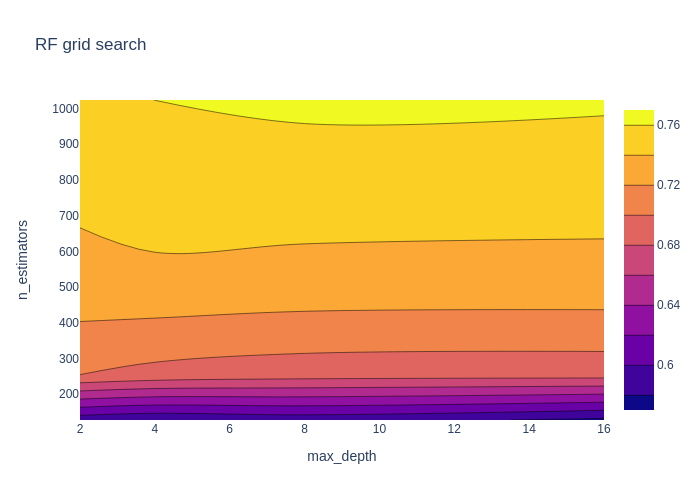

In [5]:
df = pd.DataFrame(grid)
z = df.query('split=="valid"')[criteria].values.reshape(len(max_depth_opts), len(n_estimators_opts))

fig = go.Figure(data =
    go.Contour(
        z=z,
        x=max_depth_opts, # horizontal axis
        y=n_estimators_opts # vertical axis
    ))
fig.update_layout(
    title="RF grid search",
    xaxis_title="max_depth",
    yaxis_title="n_estimators"
)
fig.show()

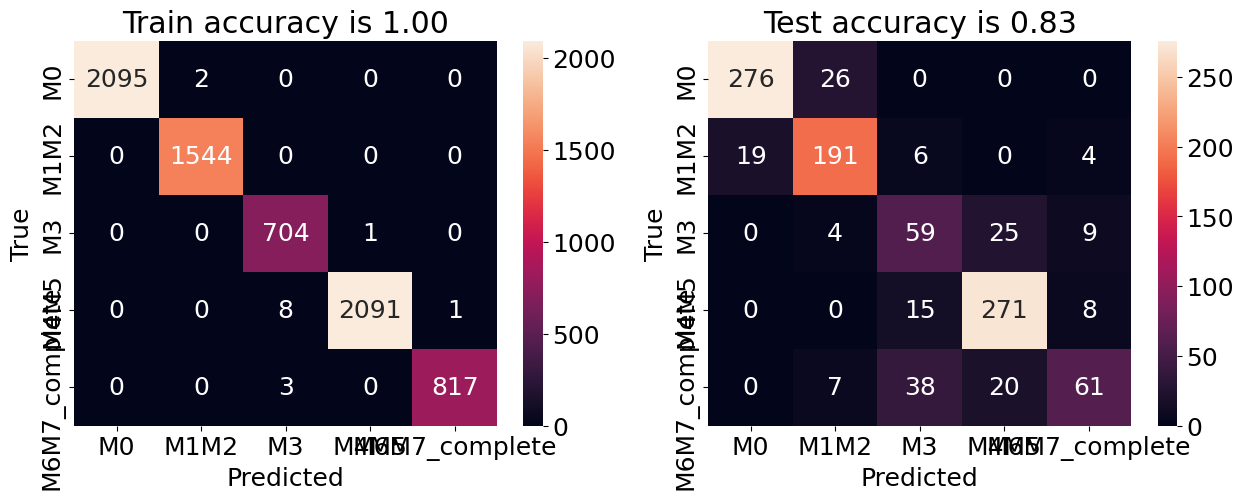

In [6]:
df_val = df.query('split=="valid"').sort_values(by=criteria, ascending=False)
best_clf_conf = list(df_val[['max_depth', 'n_estimators']].iloc[0].values)
best_clf = models[tuple(best_clf_conf)]

# Apply the model (to the training dataset)
y_trainpred = best_clf.predict(X_train)
# Apply the model (to the test dataset)
y_testpred = best_clf.predict(X_test)

# Show performance as a confusion matrix
cm_train = confusion_matrix(y_train, y_trainpred, labels = df_mitocells['cell_stage'].unique())                        
cm_test = confusion_matrix(y_test, y_testpred, labels = df_mitocells['cell_stage'].unique())                        

# plot it
labels = df_mitocells['cell_stage'].unique()
cm_train_df = pd.DataFrame(cm_train)
cm_test_df = pd.DataFrame(cm_test)
score_test = accuracy_score(y_test,y_testpred) #compute accuracy score
score_train = accuracy_score(y_train,y_trainpred) #compute accuracy score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
#train
sns.heatmap(cm_train_df, annot=True, fmt='d',ax=axes[0])
axes[0].set_title(f'Train accuracy is {score_train:.2f}')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')
axes[0].set_xticklabels([''] + labels)
axes[0].set_yticklabels([''] + labels)
#test
sns.heatmap(cm_test_df, annot=True, fmt='d',ax=axes[1])
axes[1].set_title(f'Test accuracy is {score_test:.2f}')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')
axes[1].set_xticklabels([''] + labels)
axes[1].set_yticklabels([''] + labels)
plt.show()